---
# **データマイニング特別演習　第2回課題**
## **【Pythonデータ処理】さいたま市と新潟市における夏季の気温に関する比較**
---
### 1. データの概要
　今回扱うデータは，気象庁の過去の気象データより得られるさいたま市および新潟市の気温に関する時別データをCSVファイルとしてまとめたものである．  
> [https://www.data.jma.go.jp/risk/obsdl/index.php](https://www.data.jma.go.jp/risk/obsdl/index.php)
  
### 2. データの処理
#### (1) データの読み込み

In [2]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
# %pip install kneed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time
from matplotlib.ticker import LogLocator, LogFormatter

df_saitama = pd.read_csv('data_saitama.csv', 
                        header=3, # 3行目までを無視、4行目を列名として設定
                        names=['年月日時', '気温', '品質情報', '均質番号'], # 列名を設定
                        encoding='shift-jis')
df_nigata = pd.read_csv('data_nigata.csv', 
                        header=3, # 3行目までを無視、4行目を列名として設定
                        names=['年月日時', '気温', '品質情報', '均質番号'], # 列名を設定
                        encoding='shift-jis')
for df in df_saitama, df_nigata:
    df['年月日時'] = pd.to_datetime(df['年月日時']) # '年月日時' を datetime型に変換
    display(df)

,年月日時,気温,品質情報,均質番号
0,2024-07-01 01:00:00,26.3,8,1
1,2024-07-01 02:00:00,26.6,8,1
2,2024-07-01 03:00:00,26.6,8,1
3,2024-07-01 04:00:00,26.8,8,1
4,2024-07-01 05:00:00,24.2,8,1
...,...,...,...,...
2203,2024-09-30 20:00:00,23.5,8,1
2204,2024-09-30 21:00:00,23.0,8,1
2205,2024-09-30 22:00:00,22.2,8,1
2206,2024-09-30 23:00:00,21.2,8,1


,年月日時,気温,品質情報,均質番号
0,2024-07-01 01:00:00,23.7,8,1
1,2024-07-01 02:00:00,23.2,8,1
2,2024-07-01 03:00:00,23.5,8,1
3,2024-07-01 04:00:00,23.8,8,1
4,2024-07-01 05:00:00,23.9,8,1
...,...,...,...,...
2203,2024-09-30 20:00:00,22.2,8,1
2204,2024-09-30 21:00:00,22.6,8,1
2205,2024-09-30 22:00:00,22.8,8,1
2206,2024-09-30 23:00:00,21.6,8,1


#### (2) 気温変動のグラフと気温分布のヒストグラム描画  

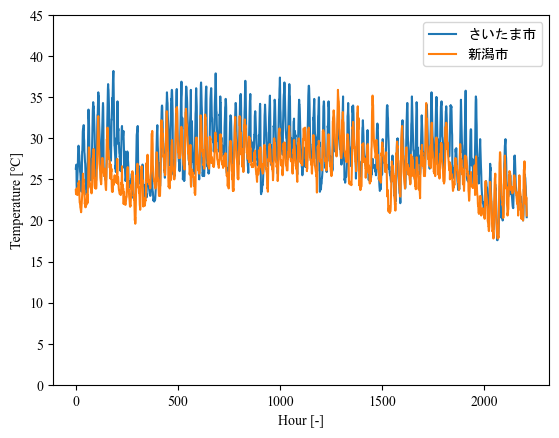

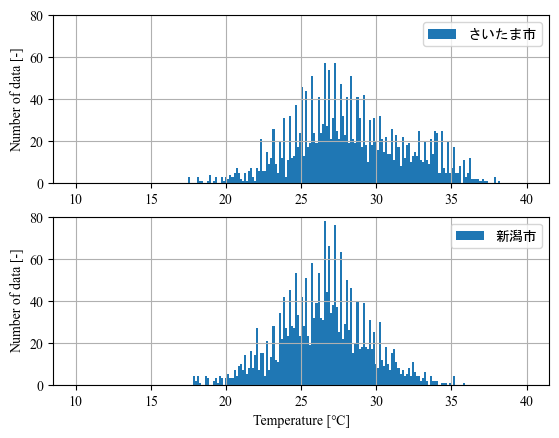

In [8]:
# 気温変動グラフ
fig = plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
ax = fig.add_subplot(1, 1, 1)
df_saitama[df_saitama['年月日時'].dt.year == 2024].plot(y='気温', ylim=[0, 45], label='さいたま市', ax=ax)
df_nigata[df_nigata['年月日時'].dt.year == 2024].plot(y='気温', ylim=[0, 45], label='新潟市', ax=ax)
plt.xlabel('Hour [-]')
plt.ylabel('Temperature [℃]')
plt.legend(prop={'family': 'MS Gothic'})
plt.show()

# 気温分布グラフ
fig = plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
df_saitama['気温'].hist(label='さいたま市', bins=len(df_saitama['気温'])//10, range=[10, 40], ax=ax1)
df_nigata['気温'].hist(label='新潟市', bins=len(df_nigata['気温'])//10, range=[10, 40], ax=ax2)
ax2.set_xlabel('Temperature [℃]')
ax1.set_ylabel('Number of data [-]')
ax2.set_ylabel('Number of data [-]')
ax1.set_ylim(0, 80)
ax2.set_ylim(0, 80)
ax1.legend(prop={'family': 'MS Gothic'})
ax2.legend(prop={'family': 'MS Gothic'})
plt.show()

### 2. 暑さ指数による危険日の比較
　[大塚製薬](https://www.otsuka.co.jp/health-and-illness/heat-disorders/wbgt/)のホームページによれば，乾球温度が35℃以上では危険であると定義されている．運動は“原則中止するべきである”とし，特に子どもの場合には中止すべきとされている．  
　この課題では，35℃以上の日数を比較することとする．
#### (1) グラフの修正

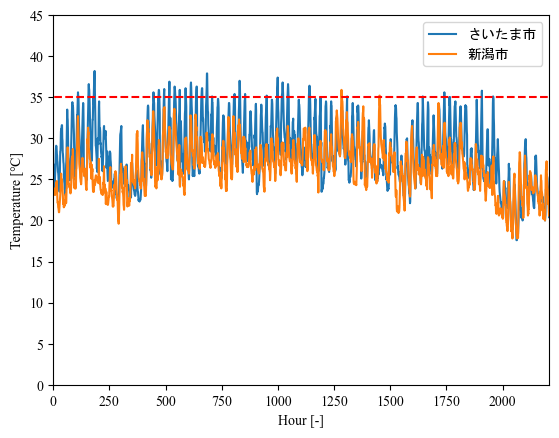

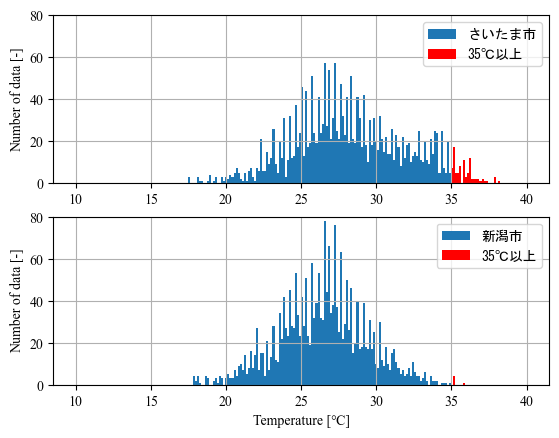

In [9]:
# 気温変動グラフ
fig = plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
ax = fig.add_subplot(1, 1, 1)
df_saitama[df_saitama['年月日時'].dt.year == 2024].plot(y='気温', ylim=[0, 45], label='さいたま市', ax=ax)
df_nigata[df_nigata['年月日時'].dt.year == 2024].plot(y='気温', ylim=[0, 45], label='新潟市', ax=ax)
plt.plot([-1000, 10000], [35, 35], linestyle='--', color='r')
plt.xlabel('Hour [-]')
plt.ylabel('Temperature [℃]')
plt.xlim(0, len(df['年月日時']))
plt.legend(prop={'family': 'MS Gothic'})
plt.show()

# 気温分布グラフ
fig = plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
df_saitama['気温'].hist(label='さいたま市', bins=len(df_saitama['気温'])//10, range=[10, 40], ax=ax1)
df_nigata['気温'].hist(label='新潟市', bins=len(df_nigata['気温'])//10, range=[10, 40], ax=ax2)
df_saitama[df_saitama['気温'] >= 35]['気温'].hist(color='r', label='35℃以上', bins=len(df_saitama['気温'])//10, range=[10, 40], ax=ax1)
df_nigata[df_nigata['気温'] >= 35]['気温'].hist(color='r', label='35℃以上', bins=len(df_nigata['気温'])//10, range=[10, 40], ax=ax2)
ax2.set_xlabel('Temperature [℃]')
ax1.set_ylabel('Number of data [-]')
ax2.set_ylabel('Number of data [-]')
ax1.set_ylim(0, 80)
ax2.set_ylim(0, 80)
ax1.legend(prop={'family': 'MS Gothic'})
ax2.legend(prop={'family': 'MS Gothic'})
plt.show()

　時系列データによれば，さいたま市は新潟市よりも高気温である傾向があり，35℃以上となる日数も多いことが確認できる．これは，夏季における気団と季節風の影響が大きいと考えられ，夏季における日本では温暖で湿潤な小笠原気団の影響が大きくなることが知られている．また，この小笠原気団（太平洋高気圧）の影響で，季節風は太平洋からユーラシア大陸に向かって吹くことが知られている．したがって，さいたま市は高温多湿となり，新潟市は山から吹き下ろす風の影響で多少涼しくなっているものと考えられる．加えて，さいたま市は内陸にあり新潟市は日本海沿岸にあることや，さいたま市は東京大都市圏に含まれるためヒートアイランド現象の影響があることなども起因すると考えられる．  
　ヒストグラムを見れば，さいたま市の方が35℃以上の日が多いことが一目瞭然であり，さいたま市は気温のばらつきが大きいのに対し，新潟市はばらつきが比較的小さいことが確認できる．これは，前述の通り，さいたま市は内陸にあり新潟市は日本海沿岸にあることから，比熱の大きい内陸の方が気温の分布にばらつきが大きくなったものと考えられる．
#### (2) 35℃以上の日数の割合

In [10]:
# 35度以上の日数をカウントする関数
def count_hot_days(df):
    return (df['気温'] >= 35).sum()

# 全体の日数をカウントする関数
def total_days(df):
    return len(df)

# 各データフレームで35度以上の日数と全体の日数をカウント
hot_days_saitama = count_hot_days(df_saitama)
hot_days_nigata = count_hot_days(df_nigata)

total_days_saitama = total_days(df_saitama)
total_days_nigata = total_days(df_nigata)

# 35度以上の日数の割合を計算
rate_saitama = hot_days_saitama / total_days_saitama * 100
rate_nigata = hot_days_nigata / total_days_nigata * 100

# 結果を表示
print(f"埼玉の35度以上の時間: {hot_days_saitama} / {total_days_saitama} 時間 ({rate_saitama:.2f}%)")
print(f"新潟の35度以上の時間: {hot_days_nigata} / {total_days_nigata} 時間 ({rate_nigata:.2f}%)")

埼玉の35度以上の時間: 90 / 2208 時間 (4.08%)
新潟の35度以上の時間: 5 / 2208 時間 (0.23%)


　7月1日から9月30日までの時別データを合計すると2208データとなる．このうち，35℃以上となった割合を計算すると，さいたま市は90時間（4.08％），新潟市は5時間（0.23%）であり，さいたま市の方が35℃以上の時間の割合が大きいことが確認できた．

### 感想  
　データの違いを分析し，その差の原因について考察することができた．差の言及については検定を用いて統計的に考察することも有効であると思った．
　